#  XGBoost Model

This code is for fit 7 XGB models for daily cases prediction and 7 XGB models for daily deaths prediction

## 1. Read in data & Preprocessing

In [19]:
import pandas as pd
import datetime
import numpy as np # linear algebra
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
final_data = pd.read_csv("final_data.csv")

In [3]:
# change the date format:
format = '%Y-%m-%d'
Da = []
for index, row in final_data.iterrows():
    #print(row['c1'], row['c2'])
    Da.append(datetime.datetime.strptime(row["Date"], format).date())
final_data["Date"] = Da

In [4]:
# Create lag varaibles
num = range(7)
final_data_list = {}
for i in num:
    final_data_test = final_data.copy(deep=True)
    j = i + 1
    final_data_test["lag"+str(j+0)+"c"] = final_data_test.groupby("State").Daily_Case.shift(j+0)
    final_data_test["lag"+str(j+1)+"c"] = final_data_test.groupby("State").Daily_Case.shift(j+1)
    final_data_test["lag"+str(j+2)+"c"] = final_data_test.groupby("State").Daily_Case.shift(j+2)
    final_data_test["lag"+str(j+3)+"c"] = final_data_test.groupby("State").Daily_Case.shift(j+3)
    final_data_test["lag"+str(j+4)+"c"] = final_data_test.groupby("State").Daily_Case.shift(j+4)
    final_data_test["lag"+str(j+5)+"c"] = final_data_test.groupby("State").Daily_Case.shift(j+5)
    final_data_test["lag"+str(j+6)+"c"] = final_data_test.groupby("State").Daily_Case.shift(j+6)
    
    final_data_test["lag"+str(j+0)+"d"] = final_data_test.groupby("State").Daily_Death.shift(j+0)
    final_data_test["lag"+str(j+1)+"d"] = final_data_test.groupby("State").Daily_Death.shift(j+1)
    final_data_test["lag"+str(j+2)+"d"] = final_data_test.groupby("State").Daily_Death.shift(j+2)
    final_data_test["lag"+str(j+3)+"d"] = final_data_test.groupby("State").Daily_Death.shift(j+3)
    final_data_test["lag"+str(j+4)+"d"] = final_data_test.groupby("State").Daily_Death.shift(j+4)
    final_data_test["lag"+str(j+5)+"d"] = final_data_test.groupby("State").Daily_Death.shift(j+5)
    final_data_test["lag"+str(j+6)+"d"] = final_data_test.groupby("State").Daily_Death.shift(j+6)
    
    final_data_test["lag"+str(j+0)+"t"] = final_data_test.groupby("State").tests_combined_total.shift(j+0)
    final_data_test["lag"+str(j+1)+"t"] = final_data_test.groupby("State").tests_combined_total.shift(j+1)
    final_data_test["lag"+str(j+2)+"t"] = final_data_test.groupby("State").tests_combined_total.shift(j+2)
    final_data_test["lag"+str(j+3)+"t"] = final_data_test.groupby("State").tests_combined_total.shift(j+3)
    final_data_test["lag"+str(j+4)+"t"] = final_data_test.groupby("State").tests_combined_total.shift(j+4)
    final_data_test["lag"+str(j+5)+"t"] = final_data_test.groupby("State").tests_combined_total.shift(j+5)
    final_data_test["lag"+str(j+6)+"t"] = final_data_test.groupby("State").tests_combined_total.shift(j+6)
    
    final_data_test["lag"+str(j+0)+"v"] = final_data_test.groupby("State").People_Fully_Vaccinated.shift(j+0)
    final_data_test["lag"+str(j+1)+"v"] = final_data_test.groupby("State").People_Fully_Vaccinated.shift(j+1)
    final_data_test["lag"+str(j+2)+"v"] = final_data_test.groupby("State").People_Fully_Vaccinated.shift(j+2)
    final_data_test["lag"+str(j+3)+"v"] = final_data_test.groupby("State").People_Fully_Vaccinated.shift(j+3)
    final_data_test["lag"+str(j+4)+"v"] = final_data_test.groupby("State").People_Fully_Vaccinated.shift(j+4)
    final_data_test["lag"+str(j+5)+"v"] = final_data_test.groupby("State").People_Fully_Vaccinated.shift(j+5)
    final_data_test["lag"+str(j+6)+"v"] = final_data_test.groupby("State").People_Fully_Vaccinated.shift(j+6)
    
    
    final_data_test = final_data_test.dropna().copy(deep = True)
    
    final_data_test['Fully_reopen']        = final_data_test['Fully_reopen'].astype(object)
    final_data_test['Mask_Mandate']        = final_data_test['Mask_Mandate'].astype(object)
    final_data_test['Vaccination_or_test'] = final_data_test['Vaccination_or_test'].astype(object)
    final_data_test['State']               = final_data_test['State'].astype(object)
    final_data_test['Region']              = final_data_test['Region'].astype(object)
    final_data_test['Division']            = final_data_test['Division'].astype(object)
    
    final_data_test = final_data_test.drop(columns=['People_Fully_Vaccinated', 'tests_combined_total']).copy(deep = True)

    final_data_list["final_data_"+str(j)] = final_data_test

In [5]:
# Hold out data after 2021-11-15 for validation
sep = [i for i in final_data_list]
thresh = datetime.date(2021, 11, 15)
predict_data_list = {}
for i in sep:
    predict_data_list[i] = final_data_list[i][final_data_list[i]['Date'] >= thresh]
    final_data_list[i] = final_data_list[i][final_data_list[i]['Date'] < thresh]

## 2. XGB model fitting

### 2.1 For daily cases prediction

In [6]:
# import the parameters tuning result 
p_case = [
    {'max_depth': 4, 
    'min_child_weight': 2, 
    'eta': 0.05, 
    'subsample': 0.6, 
    'colsample_bytree': 0.6, 
    'objective': 'reg:linear', 
    'eval_metric': 'mae'}, 
    
    {'max_depth': 5, 
    'min_child_weight': 2, 
    'eta': 0.05, 
    'subsample': 0.6, 
    'colsample_bytree': 0.4, 
    'objective': 'reg:linear', 
    'eval_metric': 'mae'}, 

    {'max_depth': 6, 
    'min_child_weight': 1, 
    'eta': 0.05, 
    'subsample': 0.6, 
    'colsample_bytree': 0.6, 
    'objective': 'reg:linear', 
    'eval_metric': 'mae'}, 
    
    {'max_depth': 6, 
    'min_child_weight': 3, 
    'eta': 0.1, 
    'subsample': 0.6, 
    'colsample_bytree': 0.6, 
    'objective': 'reg:linear', 
    'eval_metric': 'mae'}, 
    
    {'max_depth': 5, 
    'min_child_weight': 1, 
    'eta': 0.05, 
    'subsample': 0.6, 
    'colsample_bytree': 0.6, 
    'objective': 'reg:linear', 
    'eval_metric': 'mae'}, 
    
    {'max_depth': 5, 
    'min_child_weight': 2, 
    'eta': 0.05, 
    'subsample': 0.6, 
    'colsample_bytree': 0.4, 
    'objective': 'reg:linear', 
    'eval_metric': 'mae'}, 
    
    {'max_depth': 6, 
    'min_child_weight': 1, 
    'eta': 0.05, 
    'subsample': 0.6, 
    'colsample_bytree': 0.6, 
    'objective': 'reg:linear', 
    'eval_metric': 'mae'}
    
    ]

In [7]:
# fit models for daily cases prediction
model_list_case = []
for i in range(7):
    # read in data and preprocessing
    data = final_data_list["final_data_"+str(i+1)].drop(["Date","State","state"], 1)
    data = pd.get_dummies(data)
    
    # train test split
    train, test = train_test_split(data, test_size=0.2, random_state=42)
    y_train = train["Daily_Case"]
    X_train = train.drop(["Daily_Case","Daily_Death"],1)
    y_test = test["Daily_Case"]
    X_test = test.drop(["Daily_Case","Daily_Death"],1)
    
    # xgb.DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)    
    
    # fit model with best params
    model = xgb.train(
        p_case[i],
        dtrain,
        num_boost_round = 999,
        evals=[(dtest, "Test")],
        early_stopping_rounds=10
    )
    
    model_list_case.append(model)


[03:46:52] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-mae:1289.07398
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:1231.25256
[2]	Test-mae:1173.55908
[3]	Test-mae:1119.75281
[4]	Test-mae:1068.01343
[5]	Test-mae:1018.36945
[6]	Test-mae:971.38428
[7]	Test-mae:927.11328
[8]	Test-mae:887.57086
[9]	Test-mae:848.87866
[10]	Test-mae:812.34332
[11]	Test-mae:776.41040
[12]	Test-mae:742.71356
[13]	Test-mae:713.08777
[14]	Test-mae:684.14807
[15]	Test-mae:657.20160
[16]	Test-mae:630.64191
[17]	Test-mae:605.39008
[18]	Test-mae:581.83215
[19]	Test-mae:560.03638
[20]	Test-mae:539.80658
[21]	Test-mae:522.71185
[22]	Test-mae:504.02844
[23]	Test-mae:488.68155
[24]	Test-mae:472.55069
[25]	Test-mae:458.20123
[26]	Test-mae:445.35132
[27]	Test-mae:433.23254
[28]	Test-mae:421.10812
[29]	Test-mae:410.85086
[30]	Test-mae:402.17551
[31]	Test-mae:394.18024
[32]	Test-mae:386.77609
[33]	Test-mae:379.06790
[34]	

[62]	Test-mae:323.43030
[63]	Test-mae:323.15735
[64]	Test-mae:323.25314
[65]	Test-mae:323.61291
[66]	Test-mae:323.47363
[67]	Test-mae:323.23145
[68]	Test-mae:323.18899
[69]	Test-mae:323.45764
[70]	Test-mae:322.99933
[71]	Test-mae:322.64832
[72]	Test-mae:322.07043
[73]	Test-mae:322.23764
[74]	Test-mae:322.24277
[75]	Test-mae:321.38150
[76]	Test-mae:321.24774
[77]	Test-mae:321.24744
[78]	Test-mae:320.81628
[79]	Test-mae:320.84882
[80]	Test-mae:321.07284
[81]	Test-mae:321.08102
[82]	Test-mae:320.79230
[83]	Test-mae:320.62256
[84]	Test-mae:320.30429
[85]	Test-mae:320.03030
[86]	Test-mae:320.15323
[87]	Test-mae:319.43985
[88]	Test-mae:319.56705
[89]	Test-mae:319.64719
[90]	Test-mae:319.17587
[91]	Test-mae:318.92139
[92]	Test-mae:318.01315
[93]	Test-mae:318.05301
[94]	Test-mae:317.54385
[95]	Test-mae:317.43133
[96]	Test-mae:317.24304
[97]	Test-mae:317.30588
[98]	Test-mae:317.13504
[99]	Test-mae:317.05679
[100]	Test-mae:316.93665
[101]	Test-mae:316.90381
[102]	Test-mae:317.09613
[103]	Test-ma

[392]	Test-mae:295.63922
[393]	Test-mae:295.58557
[394]	Test-mae:295.55438
[395]	Test-mae:295.43210
[396]	Test-mae:295.46246
[397]	Test-mae:295.49860
[398]	Test-mae:295.46344
[399]	Test-mae:295.51508
[400]	Test-mae:295.60498
Stopping. Best iteration:
[390]	Test-mae:295.42569

[03:46:58] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[03:46:58] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-mae:1246.44641
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:1185.27173
[2]	Test-mae:1128.54956
[3]	Test-mae:1077.60986
[4]	Test-mae:1027.68811
[5]	Test-mae:980.07532
[6]	Test-mae:935.66309
[7]	Test-mae:894.02625
[8]	Test-mae:852.51477
[9]	Test-mae:813.54590
[10]	Test-mae:776.05719
[11]	Test-mae:742.80988
[12]	Test-mae:709.77960
[13]	Test-mae:680.42102
[14]	Test-mae:651.03290
[15]	Test-mae:623.35113
[16]	Test-mae:599.12616
[17]	Test-

[49]	Test-mae:348.45108
[50]	Test-mae:347.87192
[51]	Test-mae:346.94232
[52]	Test-mae:346.28271
[53]	Test-mae:344.89282
[54]	Test-mae:345.21475
[55]	Test-mae:344.72232
[56]	Test-mae:344.29715
[57]	Test-mae:344.09933
[58]	Test-mae:342.98901
[59]	Test-mae:342.70737
[60]	Test-mae:342.76364
[61]	Test-mae:343.13040
[62]	Test-mae:343.42938
[63]	Test-mae:342.30371
[64]	Test-mae:342.00769
[65]	Test-mae:341.59375
[66]	Test-mae:341.76584
[67]	Test-mae:341.26562
[68]	Test-mae:340.44092
[69]	Test-mae:340.25061
[70]	Test-mae:340.37421
[71]	Test-mae:340.08011
[72]	Test-mae:340.31125
[73]	Test-mae:340.64972
[74]	Test-mae:339.89578
[75]	Test-mae:339.95312
[76]	Test-mae:339.89609
[77]	Test-mae:340.02829
[78]	Test-mae:339.26630
[79]	Test-mae:339.24469
[80]	Test-mae:339.20889
[81]	Test-mae:339.46808
[82]	Test-mae:339.62869
[83]	Test-mae:339.39163
[84]	Test-mae:339.57089
[85]	Test-mae:338.98511
[86]	Test-mae:338.85797
[87]	Test-mae:338.90103
[88]	Test-mae:339.06513
[89]	Test-mae:338.78833
[90]	Test-mae:33

[379]	Test-mae:307.81897
[380]	Test-mae:307.85055
[381]	Test-mae:307.80719
[382]	Test-mae:307.77298
[383]	Test-mae:307.70792
[384]	Test-mae:307.65494
[385]	Test-mae:307.61939
[386]	Test-mae:307.70276
[387]	Test-mae:307.61096
[388]	Test-mae:307.66373
[389]	Test-mae:307.62189
[390]	Test-mae:307.60971
[391]	Test-mae:307.57550
[392]	Test-mae:307.57626
[393]	Test-mae:307.16016
[394]	Test-mae:307.14716
[395]	Test-mae:306.96130
[396]	Test-mae:306.95090
[397]	Test-mae:306.90021
[398]	Test-mae:306.92258
[399]	Test-mae:306.90366
[400]	Test-mae:306.88705
[401]	Test-mae:306.79025
[402]	Test-mae:306.79392
[403]	Test-mae:306.71637
[404]	Test-mae:306.78439
[405]	Test-mae:306.73148
[406]	Test-mae:306.81839
[407]	Test-mae:306.74048
[408]	Test-mae:306.54773
[409]	Test-mae:306.45117
[410]	Test-mae:306.29199
[411]	Test-mae:306.32120
[412]	Test-mae:306.35947
[413]	Test-mae:306.36813
[414]	Test-mae:306.33032
[415]	Test-mae:306.36298
[416]	Test-mae:306.11954
[417]	Test-mae:306.22412
[418]	Test-mae:306.13605


### 2.2 For daily deaths prediction

In [8]:
# import the parameters tuning result 
p_death = [{'colsample_bytree': 1.0,
  'eta': 0.005,
  'eval_metric': 'mae',
  'max_depth': 8,
  'min_child_weight': 7,
  'objective': 'reg:linear',
  'subsample': 0.9},
 {'colsample_bytree': 1.0,
  'eta': 0.005,
  'eval_metric': 'mae',
  'max_depth': 7,
  'min_child_weight': 1,
  'objective': 'reg:linear',
  'subsample': 0.8},
 {'colsample_bytree': 1.0,
  'eta': 0.005,
  'eval_metric': 'mae',
  'max_depth': 7,
  'min_child_weight': 7,
  'objective': 'reg:linear',
  'subsample': 1.0},
 {'colsample_bytree': 0.9,
  'eta': 0.005,
  'eval_metric': 'mae',
  'max_depth': 6,
  'min_child_weight': 7,
  'objective': 'reg:linear',
  'subsample': 0.9},
 {'colsample_bytree': 1.0,
  'eta': 0.005,
  'eval_metric': 'mae',
  'max_depth': 9,
  'min_child_weight': 7,
  'objective': 'reg:linear',
  'subsample': 1.0},
 {'colsample_bytree': 0.9,
  'eta': 0.005,
  'eval_metric': 'mae',
  'max_depth': 6,
  'min_child_weight': 3,
  'objective': 'reg:linear',
  'subsample': 1.0},
 {'colsample_bytree': 1.0,
  'eta': 0.01,
  'eval_metric': 'mae',
  'max_depth': 5,
  'min_child_weight': 2,
  'objective': 'reg:linear',
  'subsample': 0.8}]

In [9]:
# fit models for daily cases prediction
model_list_death = []
for i in range(7):
    # read in data and preprocessing
    data = final_data_list["final_data_"+str(i+1)].drop(["Date","State","state"], 1)
    data = pd.get_dummies(data)
    
    # train test split
    train, test = train_test_split(data, test_size=0.2, random_state=42)
    y_train = train["Daily_Death"]
    X_train = train.drop(["Daily_Case","Daily_Death"],1)
    y_test = test["Daily_Death"]
    X_test = test.drop(["Daily_Case","Daily_Death"],1)
    
    # xgb.DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)    
    
    # fit model with best params
    model = xgb.train(
        p_death[i],
        dtrain,
        num_boost_round = 999,
        evals=[(dtest, "Test")],
        early_stopping_rounds=10
    )
    
    model_list_death.append(model)


[03:47:15] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	Test-mae:17.91369
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:17.83846
[2]	Test-mae:17.76434
[3]	Test-mae:17.68909
[4]	Test-mae:17.61544
[5]	Test-mae:17.54229
[6]	Test-mae:17.46912
[7]	Test-mae:17.39696
[8]	Test-mae:17.32593
[9]	Test-mae:17.25375
[10]	Test-mae:17.18324
[11]	Test-mae:17.11251
[12]	Test-mae:17.04105
[13]	Test-mae:16.97105
[14]	Test-mae:16.90197
[15]	Test-mae:16.83379
[16]	Test-mae:16.76418
[17]	Test-mae:16.69506
[18]	Test-mae:16.62790
[19]	Test-mae:16.56221
[20]	Test-mae:16.49559
[21]	Test-mae:16.42862
[22]	Test-mae:16.36307
[23]	Test-mae:16.29688
[24]	Test-mae:16.23167
[25]	Test-mae:16.16749
[26]	Test-mae:16.10268
[27]	Test-mae:16.03802
[28]	Test-mae:15.97440
[29]	Test-mae:15.91125
[30]	Test-mae:15.84848
[31]	Test-mae:15.78619
[32]	Test-mae:15.72472
[33]	Test-mae:15.66255
[34]	Test-mae:15.60103
[35]	Test-mae:15.54049

[346]	Test-mae:7.46981
[347]	Test-mae:7.46256
[348]	Test-mae:7.45514
[349]	Test-mae:7.44894
[350]	Test-mae:7.44229
[351]	Test-mae:7.43683
[352]	Test-mae:7.43138
[353]	Test-mae:7.42419
[354]	Test-mae:7.41744
[355]	Test-mae:7.41096
[356]	Test-mae:7.40508
[357]	Test-mae:7.40001
[358]	Test-mae:7.39396
[359]	Test-mae:7.38855
[360]	Test-mae:7.38326
[361]	Test-mae:7.37786
[362]	Test-mae:7.37283
[363]	Test-mae:7.36649
[364]	Test-mae:7.35979
[365]	Test-mae:7.35403
[366]	Test-mae:7.34954
[367]	Test-mae:7.34415
[368]	Test-mae:7.34015
[369]	Test-mae:7.33517
[370]	Test-mae:7.33000
[371]	Test-mae:7.32439
[372]	Test-mae:7.31889
[373]	Test-mae:7.31332
[374]	Test-mae:7.30828
[375]	Test-mae:7.30336
[376]	Test-mae:7.29792
[377]	Test-mae:7.29299
[378]	Test-mae:7.28836
[379]	Test-mae:7.28361
[380]	Test-mae:7.27859
[381]	Test-mae:7.27317
[382]	Test-mae:7.26737
[383]	Test-mae:7.26178
[384]	Test-mae:7.25719
[385]	Test-mae:7.25279
[386]	Test-mae:7.24798
[387]	Test-mae:7.24376
[388]	Test-mae:7.23903
[389]	Test-

[80]	Test-mae:12.99908
[81]	Test-mae:12.95387
[82]	Test-mae:12.90863
[83]	Test-mae:12.86345
[84]	Test-mae:12.82045
[85]	Test-mae:12.77580
[86]	Test-mae:12.73191
[87]	Test-mae:12.68784
[88]	Test-mae:12.64625
[89]	Test-mae:12.60255
[90]	Test-mae:12.55997
[91]	Test-mae:12.51684
[92]	Test-mae:12.47271
[93]	Test-mae:12.43074
[94]	Test-mae:12.38864
[95]	Test-mae:12.34843
[96]	Test-mae:12.30640
[97]	Test-mae:12.26560
[98]	Test-mae:12.22428
[99]	Test-mae:12.18367
[100]	Test-mae:12.14438
[101]	Test-mae:12.10432
[102]	Test-mae:12.06453
[103]	Test-mae:12.02517
[104]	Test-mae:11.98542
[105]	Test-mae:11.94734
[106]	Test-mae:11.91085
[107]	Test-mae:11.87272
[108]	Test-mae:11.83547
[109]	Test-mae:11.79919
[110]	Test-mae:11.76312
[111]	Test-mae:11.72589
[112]	Test-mae:11.68946
[113]	Test-mae:11.65310
[114]	Test-mae:11.61625
[115]	Test-mae:11.57953
[116]	Test-mae:11.54426
[117]	Test-mae:11.50950
[118]	Test-mae:11.47460
[119]	Test-mae:11.44049
[120]	Test-mae:11.40684
[121]	Test-mae:11.37282
[122]	Test-m

[434]	Test-mae:7.15251
[435]	Test-mae:7.15017
[436]	Test-mae:7.14741
[437]	Test-mae:7.14460
[438]	Test-mae:7.14219
[439]	Test-mae:7.13982
[440]	Test-mae:7.13756
[441]	Test-mae:7.13501
[442]	Test-mae:7.13225
[443]	Test-mae:7.12888
[444]	Test-mae:7.12629
[445]	Test-mae:7.12329
[446]	Test-mae:7.12027
[447]	Test-mae:7.11787
[448]	Test-mae:7.11600
[449]	Test-mae:7.11423
[450]	Test-mae:7.11137
[451]	Test-mae:7.10914
[452]	Test-mae:7.10662
[453]	Test-mae:7.10409
[454]	Test-mae:7.10214
[455]	Test-mae:7.09972
[456]	Test-mae:7.09775
[457]	Test-mae:7.09612
[458]	Test-mae:7.09332
[459]	Test-mae:7.09124
[460]	Test-mae:7.08907
[461]	Test-mae:7.08701
[462]	Test-mae:7.08530
[463]	Test-mae:7.08314
[464]	Test-mae:7.08096
[465]	Test-mae:7.07848
[466]	Test-mae:7.07645
[467]	Test-mae:7.07382
[468]	Test-mae:7.07197
[469]	Test-mae:7.06991
[470]	Test-mae:7.06771
[471]	Test-mae:7.06629
[472]	Test-mae:7.06460
[473]	Test-mae:7.06349
[474]	Test-mae:7.06202
[475]	Test-mae:7.06070
[476]	Test-mae:7.05933
[477]	Test-

[93]	Test-mae:12.54710
[94]	Test-mae:12.50501
[95]	Test-mae:12.46431
[96]	Test-mae:12.42336
[97]	Test-mae:12.38129
[98]	Test-mae:12.34022
[99]	Test-mae:12.30011
[100]	Test-mae:12.25828
[101]	Test-mae:12.21834
[102]	Test-mae:12.17756
[103]	Test-mae:12.13865
[104]	Test-mae:12.09811
[105]	Test-mae:12.05867
[106]	Test-mae:12.01889
[107]	Test-mae:11.98082
[108]	Test-mae:11.94149
[109]	Test-mae:11.90197
[110]	Test-mae:11.86466
[111]	Test-mae:11.82731
[112]	Test-mae:11.78934
[113]	Test-mae:11.75224
[114]	Test-mae:11.71454
[115]	Test-mae:11.67702
[116]	Test-mae:11.63952
[117]	Test-mae:11.60238
[118]	Test-mae:11.56463
[119]	Test-mae:11.52925
[120]	Test-mae:11.49367
[121]	Test-mae:11.45801
[122]	Test-mae:11.42259
[123]	Test-mae:11.38754
[124]	Test-mae:11.35297
[125]	Test-mae:11.31919
[126]	Test-mae:11.28497
[127]	Test-mae:11.25080
[128]	Test-mae:11.21651
[129]	Test-mae:11.18382
[130]	Test-mae:11.15139
[131]	Test-mae:11.11795
[132]	Test-mae:11.08553
[133]	Test-mae:11.05355
[134]	Test-mae:11.02242

[447]	Test-mae:7.31400
[448]	Test-mae:7.31176
[449]	Test-mae:7.31000
[450]	Test-mae:7.30838
[451]	Test-mae:7.30614
[452]	Test-mae:7.30478
[453]	Test-mae:7.30247
[454]	Test-mae:7.30035
[455]	Test-mae:7.29929
[456]	Test-mae:7.29786
[457]	Test-mae:7.29660
[458]	Test-mae:7.29551
[459]	Test-mae:7.29394
[460]	Test-mae:7.29237
[461]	Test-mae:7.29063
[462]	Test-mae:7.28959
[463]	Test-mae:7.28825
[464]	Test-mae:7.28623
[465]	Test-mae:7.28466
[466]	Test-mae:7.28326
[467]	Test-mae:7.28212
[468]	Test-mae:7.28042
[469]	Test-mae:7.27928
[470]	Test-mae:7.27774
[471]	Test-mae:7.27630
[472]	Test-mae:7.27474
[473]	Test-mae:7.27343
[474]	Test-mae:7.27230
[475]	Test-mae:7.27154
[476]	Test-mae:7.27018
[477]	Test-mae:7.26842
[478]	Test-mae:7.26686
[479]	Test-mae:7.26622
[480]	Test-mae:7.26477
[481]	Test-mae:7.26283
[482]	Test-mae:7.26168
[483]	Test-mae:7.26033
[484]	Test-mae:7.25864
[485]	Test-mae:7.25750
[486]	Test-mae:7.25641
[487]	Test-mae:7.25501
[488]	Test-mae:7.25326
[489]	Test-mae:7.25219
[490]	Test-

[196]	Test-mae:8.89014
[197]	Test-mae:8.86950
[198]	Test-mae:8.85046
[199]	Test-mae:8.83045
[200]	Test-mae:8.81188
[201]	Test-mae:8.79367
[202]	Test-mae:8.77441
[203]	Test-mae:8.75650
[204]	Test-mae:8.73832
[205]	Test-mae:8.72052
[206]	Test-mae:8.70277
[207]	Test-mae:8.68655
[208]	Test-mae:8.66897
[209]	Test-mae:8.65202
[210]	Test-mae:8.63474
[211]	Test-mae:8.61851
[212]	Test-mae:8.60071
[213]	Test-mae:8.58302
[214]	Test-mae:8.56603
[215]	Test-mae:8.54950
[216]	Test-mae:8.53318
[217]	Test-mae:8.51602
[218]	Test-mae:8.49954
[219]	Test-mae:8.48320
[220]	Test-mae:8.46748
[221]	Test-mae:8.45071
[222]	Test-mae:8.43569
[223]	Test-mae:8.42165
[224]	Test-mae:8.40485
[225]	Test-mae:8.38920
[226]	Test-mae:8.37410
[227]	Test-mae:8.35931
[228]	Test-mae:8.34468
[229]	Test-mae:8.33032
[230]	Test-mae:8.31536
[231]	Test-mae:8.30055
[232]	Test-mae:8.28585
[233]	Test-mae:8.27272
[234]	Test-mae:8.25804
[235]	Test-mae:8.24353
[236]	Test-mae:8.23063
[237]	Test-mae:8.21692
[238]	Test-mae:8.20396
[239]	Test-

[553]	Test-mae:6.76538
[554]	Test-mae:6.76471
[555]	Test-mae:6.76358
[556]	Test-mae:6.76313
[557]	Test-mae:6.76306
[558]	Test-mae:6.76253
[559]	Test-mae:6.76144
[560]	Test-mae:6.75990
[561]	Test-mae:6.75856
[562]	Test-mae:6.75812
[563]	Test-mae:6.75734
[564]	Test-mae:6.75729
[565]	Test-mae:6.75700
[566]	Test-mae:6.75658
[567]	Test-mae:6.75612
[568]	Test-mae:6.75526
[569]	Test-mae:6.75389
[570]	Test-mae:6.75322
[571]	Test-mae:6.75244
[572]	Test-mae:6.75195
[573]	Test-mae:6.75142
[574]	Test-mae:6.75123
[575]	Test-mae:6.75047
[576]	Test-mae:6.75041
[577]	Test-mae:6.74980
[578]	Test-mae:6.74982
[579]	Test-mae:6.74862
[580]	Test-mae:6.74850
[581]	Test-mae:6.74819
[582]	Test-mae:6.74785
[583]	Test-mae:6.74801
[584]	Test-mae:6.74771
[585]	Test-mae:6.74685
[586]	Test-mae:6.74667
[587]	Test-mae:6.74665
[588]	Test-mae:6.74723
[589]	Test-mae:6.74704
[590]	Test-mae:6.74666
[591]	Test-mae:6.74646
[592]	Test-mae:6.74599
[593]	Test-mae:6.74614
[594]	Test-mae:6.74640
[595]	Test-mae:6.74578
[596]	Test-

[258]	Test-mae:7.97629
[259]	Test-mae:7.96520
[260]	Test-mae:7.95390
[261]	Test-mae:7.94256
[262]	Test-mae:7.93163
[263]	Test-mae:7.92035
[264]	Test-mae:7.90958
[265]	Test-mae:7.89873
[266]	Test-mae:7.88777
[267]	Test-mae:7.87726
[268]	Test-mae:7.86647
[269]	Test-mae:7.85572
[270]	Test-mae:7.84508
[271]	Test-mae:7.83385
[272]	Test-mae:7.82367
[273]	Test-mae:7.81302
[274]	Test-mae:7.80329
[275]	Test-mae:7.79333
[276]	Test-mae:7.78307
[277]	Test-mae:7.77371
[278]	Test-mae:7.76336
[279]	Test-mae:7.75396
[280]	Test-mae:7.74401
[281]	Test-mae:7.73466
[282]	Test-mae:7.72437
[283]	Test-mae:7.71530
[284]	Test-mae:7.70562
[285]	Test-mae:7.69671
[286]	Test-mae:7.68715
[287]	Test-mae:7.67870
[288]	Test-mae:7.66901
[289]	Test-mae:7.66071
[290]	Test-mae:7.65159
[291]	Test-mae:7.64237
[292]	Test-mae:7.63413
[293]	Test-mae:7.62563
[294]	Test-mae:7.61706
[295]	Test-mae:7.60847
[296]	Test-mae:7.59986
[297]	Test-mae:7.59206
[298]	Test-mae:7.58384
[299]	Test-mae:7.57600
[300]	Test-mae:7.56839
[301]	Test-

[33]	Test-mae:14.38928
[34]	Test-mae:14.33040
[35]	Test-mae:14.27246
[36]	Test-mae:14.21368
[37]	Test-mae:14.15608
[38]	Test-mae:14.09843
[39]	Test-mae:14.04135
[40]	Test-mae:13.98477
[41]	Test-mae:13.92818
[42]	Test-mae:13.87192
[43]	Test-mae:13.81548
[44]	Test-mae:13.76022
[45]	Test-mae:13.70555
[46]	Test-mae:13.65062
[47]	Test-mae:13.59705
[48]	Test-mae:13.54287
[49]	Test-mae:13.49033
[50]	Test-mae:13.43775
[51]	Test-mae:13.38442
[52]	Test-mae:13.33158
[53]	Test-mae:13.27927
[54]	Test-mae:13.22794
[55]	Test-mae:13.17625
[56]	Test-mae:13.12480
[57]	Test-mae:13.07313
[58]	Test-mae:13.02275
[59]	Test-mae:12.97219
[60]	Test-mae:12.92227
[61]	Test-mae:12.87182
[62]	Test-mae:12.82264
[63]	Test-mae:12.77283
[64]	Test-mae:12.72333
[65]	Test-mae:12.67483
[66]	Test-mae:12.62653
[67]	Test-mae:12.57928
[68]	Test-mae:12.53171
[69]	Test-mae:12.48501
[70]	Test-mae:12.43802
[71]	Test-mae:12.39095
[72]	Test-mae:12.34488
[73]	Test-mae:12.29929
[74]	Test-mae:12.25394
[75]	Test-mae:12.20832
[76]	Test-m

[388]	Test-mae:7.04399
[389]	Test-mae:7.04283
[390]	Test-mae:7.04010
[391]	Test-mae:7.03855
[392]	Test-mae:7.03698
[393]	Test-mae:7.03533
[394]	Test-mae:7.03331
[395]	Test-mae:7.03108
[396]	Test-mae:7.02860
[397]	Test-mae:7.02710
[398]	Test-mae:7.02503
[399]	Test-mae:7.02321
[400]	Test-mae:7.02138
[401]	Test-mae:7.01967
[402]	Test-mae:7.01848
[403]	Test-mae:7.01608
[404]	Test-mae:7.01438
[405]	Test-mae:7.01290
[406]	Test-mae:7.01117
[407]	Test-mae:7.00993
[408]	Test-mae:7.00842
[409]	Test-mae:7.00673
[410]	Test-mae:7.00471
[411]	Test-mae:7.00364
[412]	Test-mae:7.00192
[413]	Test-mae:7.00047
[414]	Test-mae:6.99929
[415]	Test-mae:6.99720
[416]	Test-mae:6.99597
[417]	Test-mae:6.99505
[418]	Test-mae:6.99298
[419]	Test-mae:6.99166
[420]	Test-mae:6.99008
[421]	Test-mae:6.98869
[422]	Test-mae:6.98734
[423]	Test-mae:6.98521
[424]	Test-mae:6.98436
[425]	Test-mae:6.98372
[426]	Test-mae:6.98206
[427]	Test-mae:6.98044
[428]	Test-mae:6.97893
[429]	Test-mae:6.97749
[430]	Test-mae:6.97603
[431]	Test-

[193]	Test-mae:7.04958
[194]	Test-mae:7.04323
[195]	Test-mae:7.03736
[196]	Test-mae:7.03235
[197]	Test-mae:7.02527
[198]	Test-mae:7.01919
[199]	Test-mae:7.01366
[200]	Test-mae:7.00883
[201]	Test-mae:7.00420
[202]	Test-mae:6.99722
[203]	Test-mae:6.99157
[204]	Test-mae:6.98548
[205]	Test-mae:6.97799
[206]	Test-mae:6.97508
[207]	Test-mae:6.97170
[208]	Test-mae:6.96484
[209]	Test-mae:6.96092
[210]	Test-mae:6.95633
[211]	Test-mae:6.95145
[212]	Test-mae:6.94676
[213]	Test-mae:6.94291
[214]	Test-mae:6.93897
[215]	Test-mae:6.93393
[216]	Test-mae:6.92877
[217]	Test-mae:6.92446
[218]	Test-mae:6.92096
[219]	Test-mae:6.91782
[220]	Test-mae:6.91476
[221]	Test-mae:6.91183
[222]	Test-mae:6.90817
[223]	Test-mae:6.90567
[224]	Test-mae:6.90508
[225]	Test-mae:6.90170
[226]	Test-mae:6.89766
[227]	Test-mae:6.89562
[228]	Test-mae:6.89393
[229]	Test-mae:6.89029
[230]	Test-mae:6.88935
[231]	Test-mae:6.88661
[232]	Test-mae:6.88569
[233]	Test-mae:6.88348
[234]	Test-mae:6.88095
[235]	Test-mae:6.87715
[236]	Test-

## 3. Model Evaluation

### 3.1 RMSE

In [24]:
# predict on test for case models
dtrain_list = []
dtest_list = []
y_test_list = []
y_pred_list = []

for i in range(7):
    # read in data and preprocessing
    data = final_data_list["final_data_"+str(i+1)].drop(["Date","State","state"], 1)
    data = pd.get_dummies(data)
    
    # train test split
    train, test = train_test_split(data, test_size=0.2, random_state=42)
    y_train = train["Daily_Case"]
    X_train = train.drop(["Daily_Case","Daily_Death"],1)
    y_test = test["Daily_Case"]
    X_test = test.drop(["Daily_Case","Daily_Death"],1)
    
    # xgb.DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test) 
    
    # predict
    y_pred = model_list_case[i].predict(dtest)
    y_pred[y_pred<0] = 0
    
    # append
    dtrain_list.append(dtrain)
    dtest_list.append(dtest)
    y_test_list.append(y_test)
    y_pred_list.append(y_pred)
    

# Calculate RMSE for daily cases prediction model
RMSE_case = []
for i in range(7):
    RMSE_case.append(np.sqrt(mean_squared_error(y_test_list[i], y_pred_list[i])))
    
df = {
        "Model": ["Model_"+str(i+1)+"_case" for i in range(7)],
        "RMSE": RMSE_case,
    }

RMSE_case = pd.DataFrame(df)

In [25]:
# predict on test for death models
dtrain_list = []
dtest_list = []
y_test_list = []
y_pred_list = []

for i in range(7):
    # read in data and preprocessing
    data = final_data_list["final_data_"+str(i+1)].drop(["Date","State","state"], 1)
    data = pd.get_dummies(data)
    
    # train test split
    train, test = train_test_split(data, test_size=0.2, random_state=42)
    y_train = train["Daily_Death"]
    X_train = train.drop(["Daily_Case","Daily_Death"],1)
    y_test = test["Daily_Death"]
    X_test = test.drop(["Daily_Case","Daily_Death"],1)
    
    # xgb.DMatrix
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test) 
    
    # predict
    y_pred = model_list_death[i].predict(dtest)
    y_pred[y_pred<0] = 0
    
    # append
    dtrain_list.append(dtrain)
    dtest_list.append(dtest)
    y_test_list.append(y_test)
    y_pred_list.append(y_pred)
    
    
# Calculate RMSE for daily deaths prediction model
RMSE_death = []
for i in range(7):
    RMSE_death.append(np.sqrt(mean_squared_error(y_test_list[i], y_pred_list[i])))
    
df = {
        "Model": ["Model_"+str(i+1)+"_death" for i in range(7)],
        "RMSE": RMSE_death,
    }

RMSE_death = pd.DataFrame(df)   

In [28]:
RMSE = pd.concat([RMSE_case, RMSE_death]).reset_index(drop = True)

In [29]:
RMSE

,Model,RMSE
0,Model_1_case,661.471829
1,Model_2_case,720.751978
2,Model_3_case,758.498383
3,Model_4_case,866.286341
4,Model_5_case,812.200403
5,Model_6_case,914.660485
6,Model_7_case,914.271360
7,Model_1_death,15.898748
8,Model_2_death,15.970814
9,Model_3_death,18.392707


### 3.2 Feature Importance Plot

<AxesSubplot:>

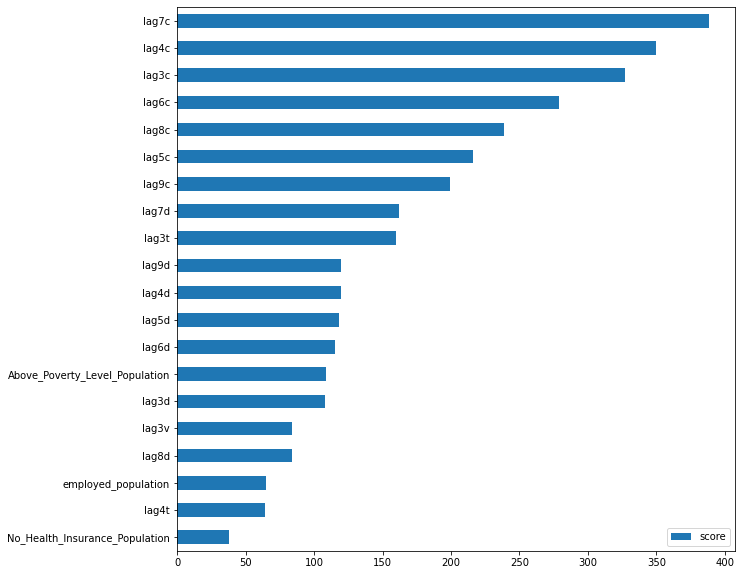

In [15]:
# plot feature importance
feature_important = model_list_case[2].get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"])
data.nlargest(20, columns="score").sort_values(by = "score", ascending=True).plot(kind='barh', figsize = (10,10)) ## plot top 40 features

<AxesSubplot:>

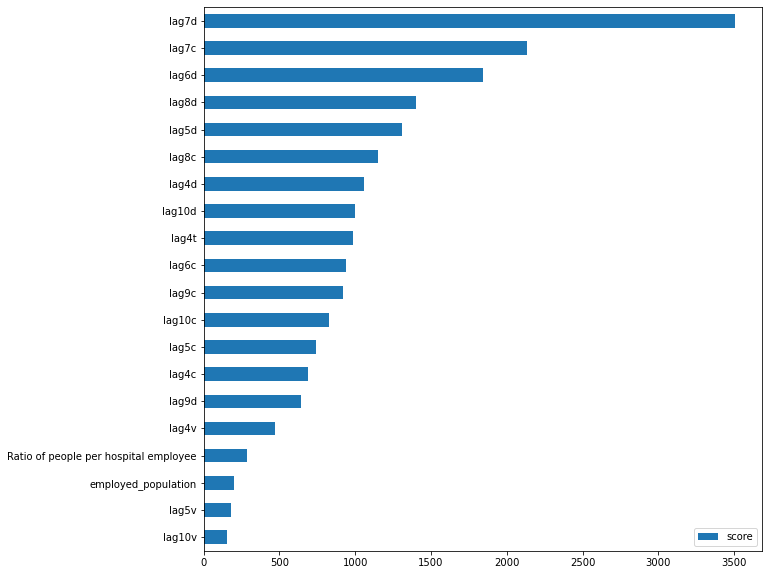

In [31]:
# plot feature importance
feature_important = model_list_death[3].get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"])
data.nlargest(20, columns="score").sort_values(by = "score", ascending=True).plot(kind='barh', figsize = (10,10)) ## plot top 40 features

## 4. Model Saving

In [16]:
# save the model to disk
for i in range(7):
    
    model_list_case[i].save_model("XGB_model_"+str(i+1)+"_case.model")
    
    model_list_death[i].save_model("XGB_model_"+str(i+1)+"_death.model")